In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [6]:
 ids = [211,  224,  230,  498,  569,  618,  707,  755,  780, 1082, 1086,
       1255, 1421, 1422, 1467, 1479, 1567, 1694, 1788, 1792, 1813, 1880,
       1928, 2038, 2045, 2078, 2190, 2215, 2229, 2255, 2265, 2345, 2346,
       2351, 2378, 2407, 2506, 2517, 2531, 2540, 2567, 2767, 2813, 3022,
       3189, 3224, 3234, 3285, 3477, 3531, 3677, 3678, 3788, 4229, 4288,
       4326, 4334, 4355, 4375, 4395, 4617, 4626, 4646, 4688, 4729, 4735,
       4759, 4825, 4909, 4943, 4948, 5013, 5032, 5041, 5284, 5335, 5387,
       5469, 5540, 5566, 5601, 5700, 5879, 5911, 5913, 5960, 5968, 6059,
       6133, 6218, 6232, 63160]

In [7]:
len(ids)

92

In [8]:
isin = df.loc[df['caseid'].isin(ids)]

In [9]:
# shrink dataset to the first 6 cases 
caseids = isin.caseid.unique()
caseids


array([ 211,  224,  230,  498,  569,  618,  707,  755,  780, 1082, 1086,
       1255, 1421, 1422, 1467, 1479, 1567, 1694, 1788, 1792, 1813, 1880,
       1928, 2038, 2045, 2078, 2190, 2215, 2229, 2255, 2265, 2345, 2346,
       2351, 2378, 2407, 2506, 2517, 2531, 2540, 2567, 2767, 2813, 3022,
       3189, 3224, 3234, 3285, 3477, 3531, 3677, 3678, 3788, 4229, 4288,
       4326, 4334, 4355, 4375, 4395, 4617, 4626, 4646, 4688, 4729, 4735,
       4759, 4825, 4909, 4943, 4948, 5013, 5032, 5041, 5284, 5335, 5387,
       5469, 5540, 5566, 5601, 5700, 5879, 5911, 5913, 5960, 5968, 6059,
       6133, 6218, 6232])

In [10]:
# only keep MBP variable
data = isin[["Solar8000/NIBP_MBP", 'caseid']].copy()

## Preprocessing

In [11]:
MINUTES_AHEAD = 5  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 100  # Batch size for learning
MAX_CASES = 600  # Maximum number of cases for this example

In [12]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = data.loc[data.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (150 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 150]
        segy = mbps[i + 150 + MINUTES_AHEAD * 30:i + 150 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 211...4029 samples 0 (0.0 %) events
loading 224...2807 samples 0 (0.0 %) events
loading 230...2094 samples 1344 (64.2 %) events
loading 498...6705 samples 0 (0.0 %) events
loading 569...3832 samples 466 (12.2 %) events
loading 618...5312 samples 2046 (38.5 %) events
loading 707...6157 samples 688 (11.2 %) events
loading 755...1086 samples 0 (0.0 %) events
loading 780...5664 samples 1144 (20.2 %) events
loading 1082...5473 samples 0 (0.0 %) events
loading 1086...1774 samples 0 (0.0 %) events
loading 1255...3341 samples 276 (8.3 %) events
loading 1421...2529 samples 532 (21.0 %) events
loading 1422...1982 samples 0 (0.0 %) events
loading 1467...3411 samples 946 (27.7 %) events
loading 1479...2936 samples 0 (0.0 %) events
loading 1567...1864 samples 942 (50.5 %) events
loading 1694...2008 samples 0 (0.0 %) events
loading 1788...3026 samples 2186 (72.2 %) events
loading 1792...3872 samples 88 (2.3 %) events
loading 1813...3557 samples 0 (0.0 %) events
loading 1880...5769 samples 91

## Splitting samples into training and testing dataset

In [13]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'600cases 5ahead batchsize=100 total 337956, train 264125 (18310 events 6.9%), test 73831 (2654 events 3.6%)'

## Model building and training

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

2022-08-15 11:46:28.084596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
2378/2378 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.8820 - auc: 0.8135
Epoch 1: val_loss improved from inf to 0.11322, saving model to output/weights.hdf5
2378/2378 [==============================] - 169s 70ms/step - loss: 0.6044 - accuracy: 0.8820 - auc: 0.8135 - val_loss: 0.1132 - val_accuracy: 0.9915 - val_auc: 0.9346
Epoch 2/100
2378/2378 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.8881 - auc: 0.8188
Epoch 2: val_loss did not improve from 0.11322
2378/2378 [==============================] - 167s 70ms/step - loss: 0.5952 - accuracy: 0.8881 - auc: 0.8188 - val_loss: 0.1364 - val_accuracy: 0.9884 - val_auc: 0.9361
Epoch 3/100
2378/2378 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.8860 - auc: 0.8201
Epoch 3: val_loss did not improve from 0.11322
2378/2378 [==============================] - 179s 75ms/step - loss: 0.5935 - accuracy: 0.8860 - auc: 0.8201 - val_loss: 0.1221 - val_accuracy: 0.98

2127

## Evaluation of the model performance

In [16]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [17]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



2308/2308 [==============================] - 38s 16ms/step
auroc=0.779, auprc=0.187 acc=0.955, F1=0.261, PPV=31.4, NPV=97.1, TN=69880, fp=1297, fn=2061, TP=593


In [17]:
auroc

0.7980645973028302

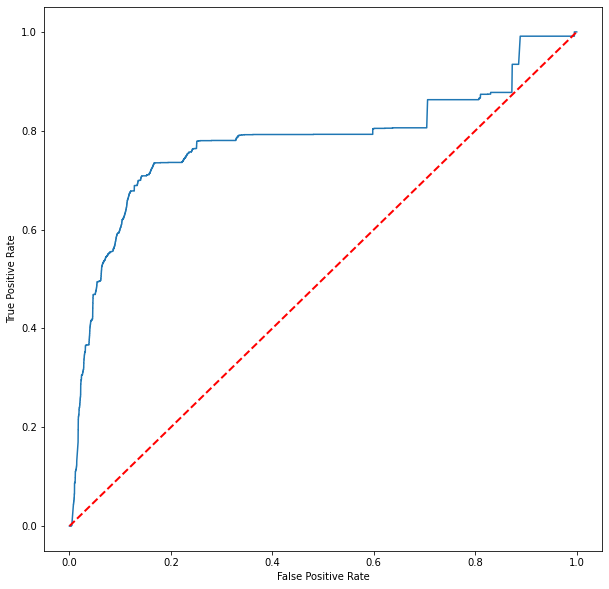

<function matplotlib.pyplot.show(close=None, block=None)>

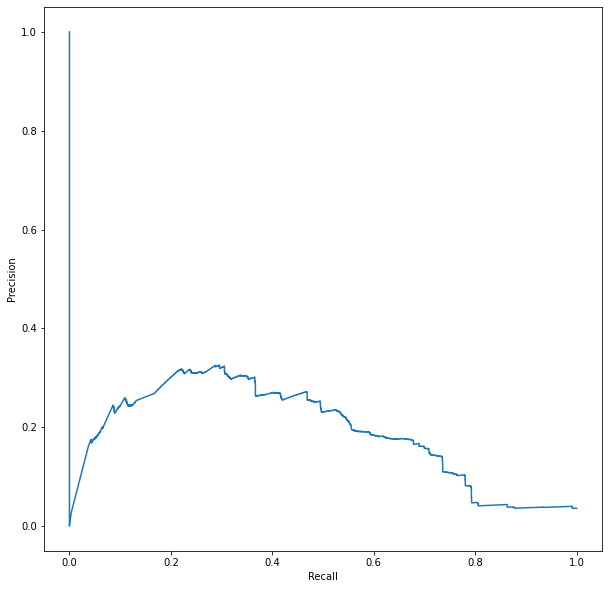

In [18]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

243/243 [==============================] - 3s 13ms/step
Print error: 5041	0.14457354699932903	


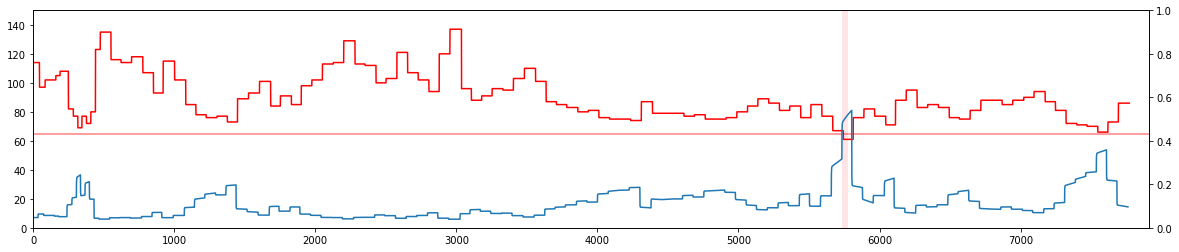

128/128 [==============================] - 1s 12ms/step
Print error: 5284	0.3856281353345431	


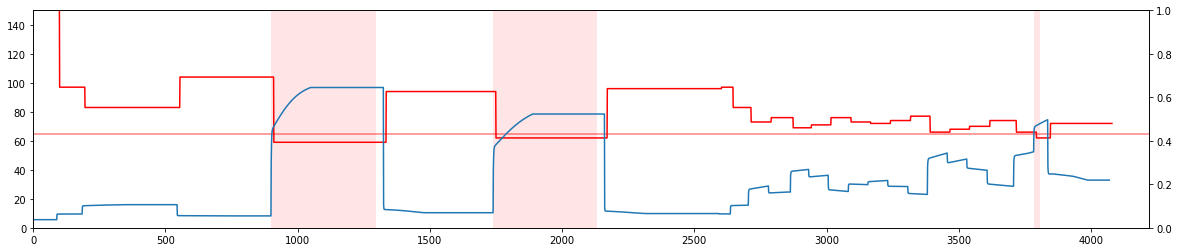

245/245 [==============================] - 8s 31ms/step
Print error: 5335	0.21344084899028695	


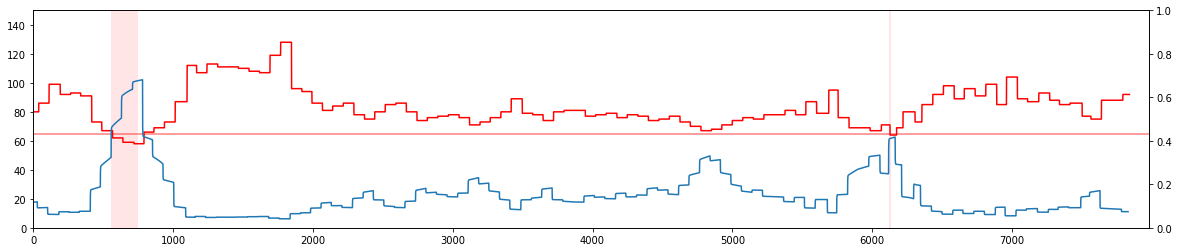

99/99 [==============================] - 3s 29ms/step
Print error: 5387	0.312930037722441	


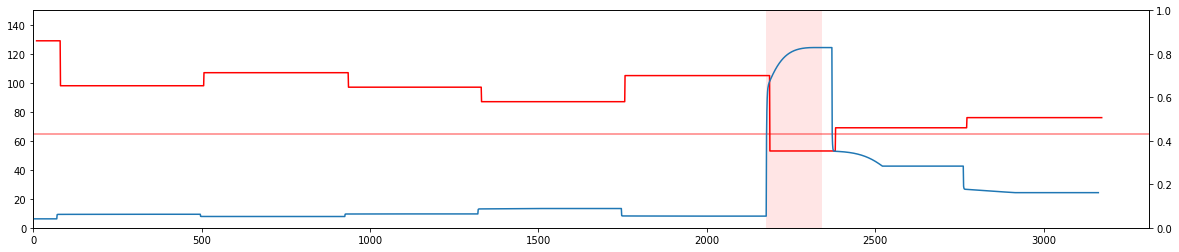

149/149 [==============================] - 4s 27ms/step
Print error: 5469	0.09797429270632596	


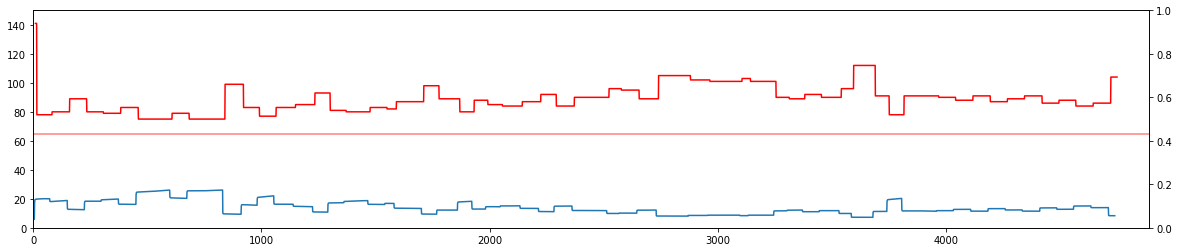

141/141 [==============================] - 4s 23ms/step
Print error: 5540	0.1540494214168704	


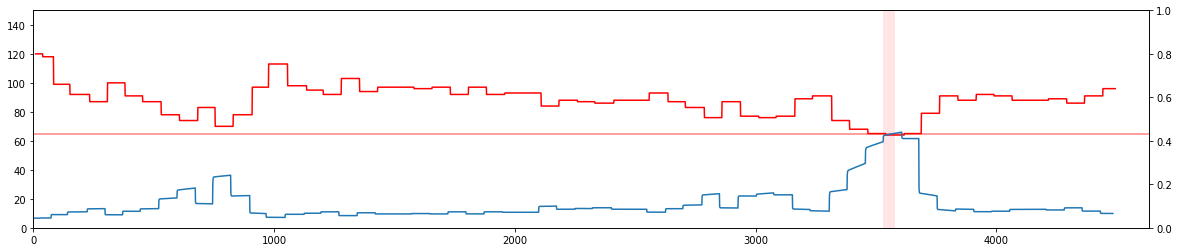

51/51 [==============================] - 1s 26ms/step
Print error: 5566	0.04762482202880251	


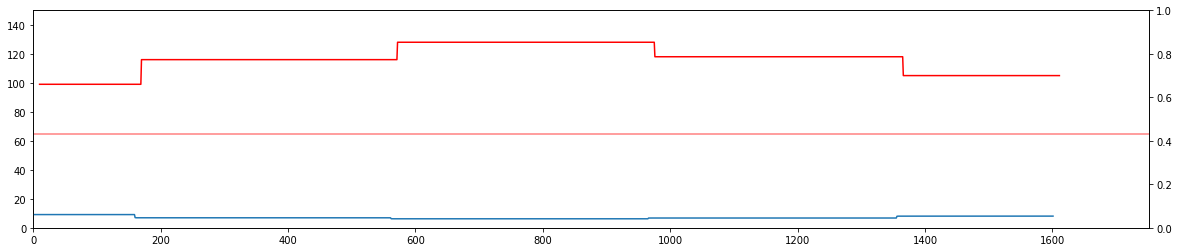

62/62 [==============================] - 2s 24ms/step
Print error: 5601	0.2104483425184095	


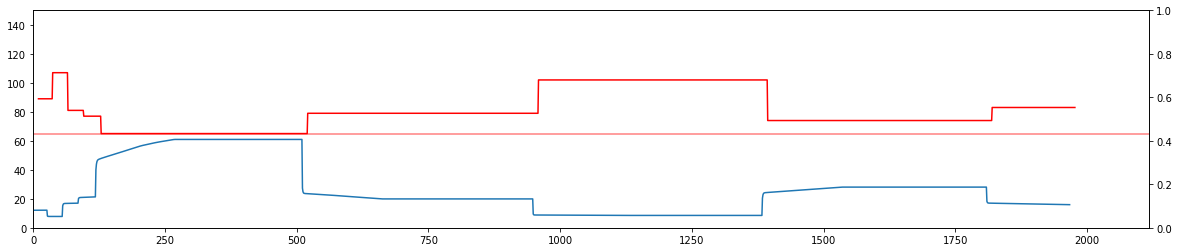

139/139 [==============================] - 3s 22ms/step
Print error: 5700	0.35625153591427233	


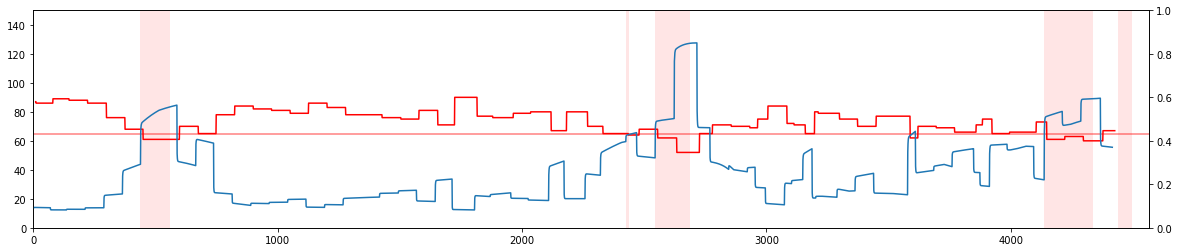

267/267 [==============================] - 9s 31ms/step
Print error: 5879	0.22657991210851447	


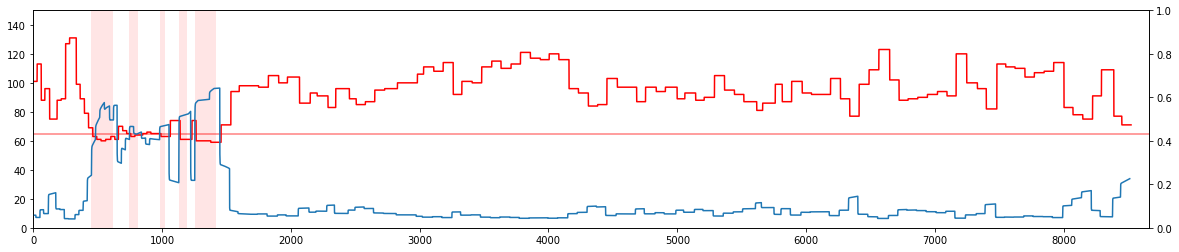

47/47 [==============================] - 2s 32ms/step
Print error: 5911	0.06556947919674458	


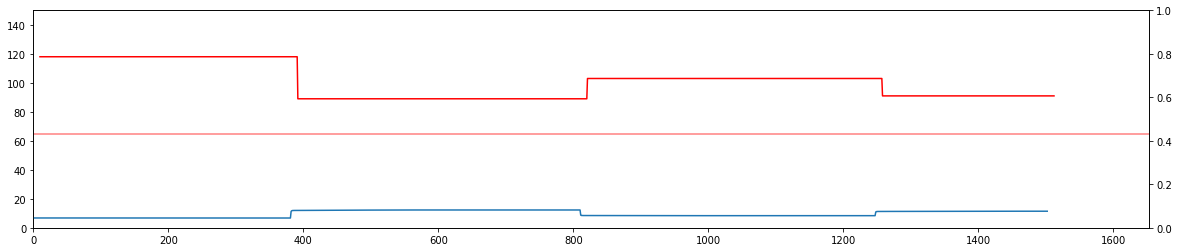

152/152 [==============================] - 5s 30ms/step
Print error: 5913	0.1920109752259979	


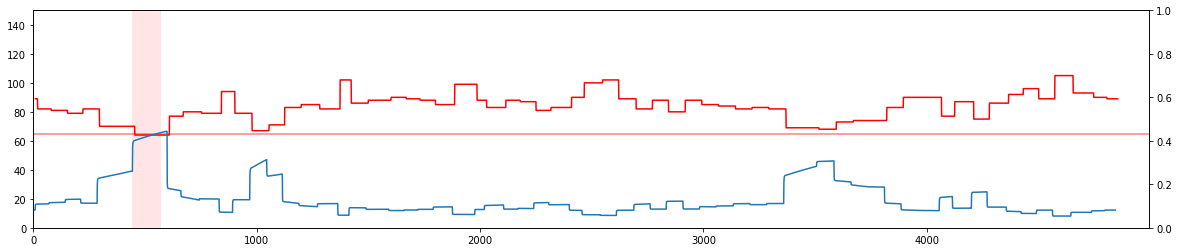

64/64 [==============================] - 2s 30ms/step
Print error: 5960	0.16382977464361081	


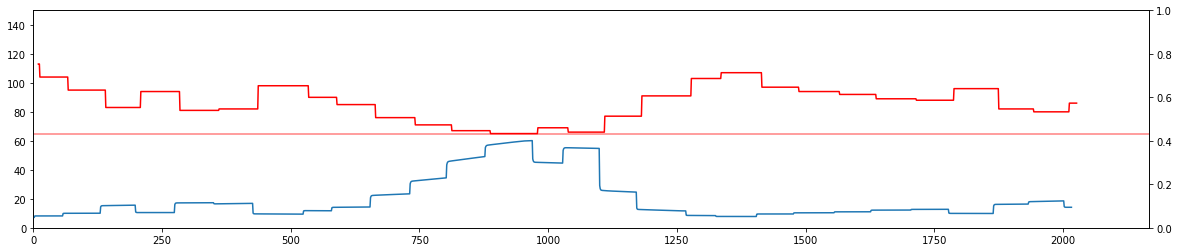

196/196 [==============================] - 6s 30ms/step
Print error: 5968	0.12788606584283768	


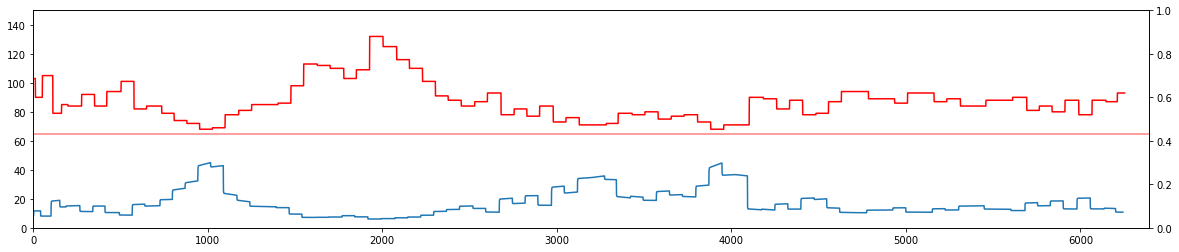

83/83 [==============================] - 2s 23ms/step
Print error: 6059	0.14994102625061437	


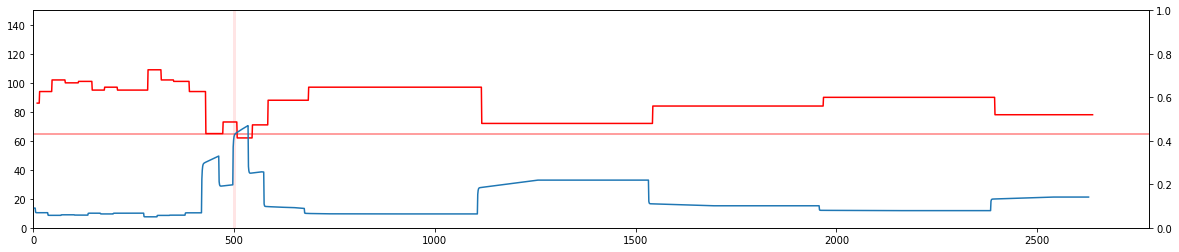

39/39 [==============================] - 1s 24ms/step
Print error: 6133	0.12419164319847137	


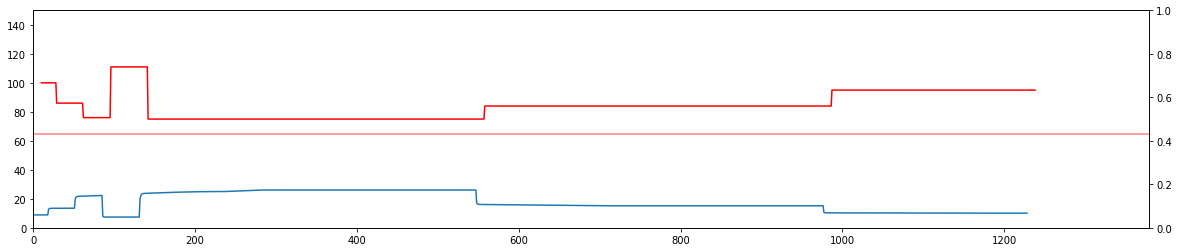

55/55 [==============================] - 1s 15ms/step
Print error: 6218	0.20328184637910238	


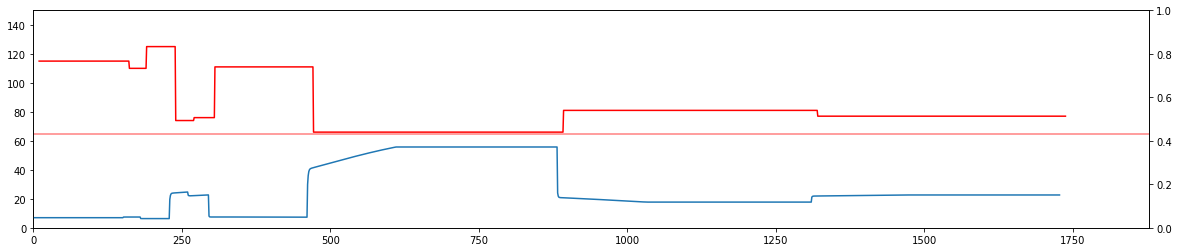

159/159 [==============================] - 4s 28ms/step
Print error: 6232	0.18317423228681792	


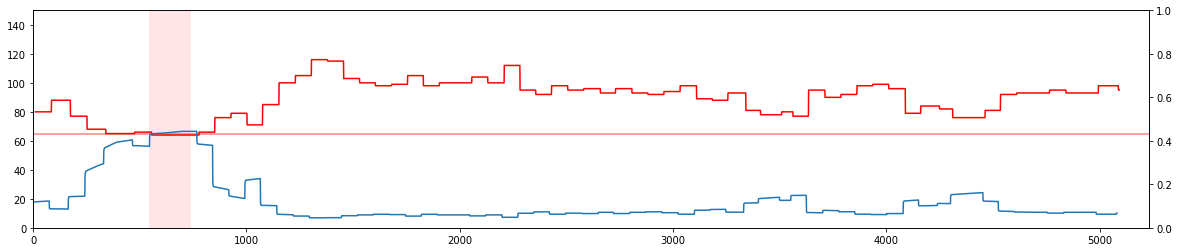

In [19]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()